# Machine Learning Techniques - ISIS4219 (Segundo Semestre - 2021)
# Proyecto final

## Integrantes

*   Integrante 1: Daniel Mateo Guatibonza Solano - 201611360
*   Integrante 2: Raquel Andrea Cerda Montañez - 201533520
*   Integrante 3: Sergio Eduardo Cárdenas Landazabal - 201613444


## Librerías necesarias
En primera instancia, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción de los modelos.

In [40]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import os
from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16

import tensorflow as tf
import tensorflow_addons.losses.giou_loss as GIoU_Loss

from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import cv2

import re

from skimage import io

from typing import Optional, Union, List, Tuple, ByteString, Dict

## Lectura de datos
Dado que el conjunto de datos base presenta imágenes etiquetadas para varias personas, una vez aplicado el filtro para utilizar solo los datos asociados a una persona por medio del script de MatLab adjunto, se obtienen 3 archivos CSV asociados a los tres conjuntos a utilizar: entrenamiento, validación y test. En este sentido, inicialmente se cargan estos archivos por medio de *pandas* como se muestra en seguida.

In [2]:
train_data = pd.read_csv('train.csv', dtype=str).dropna()
train_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000562243.jpg,86,58,564,628,5,3,9
1,mscoco/images/COCO_train2014_000000288841.jpg,485,149,605,473,6,4,7
2,mscoco/images/COCO_val2014_000000558171.jpg,305,92,461,465,7,8,8
3,mscoco/images/COCO_train2014_000000369575.jpg,221,63,448,372,8,9,8
4,mscoco/images/COCO_train2014_000000213009.jpg,44,143,150,288,7,9,10


In [3]:
val_data = pd.read_csv('val.csv', dtype=str).dropna()
val_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000020459.jpg,109,108,401,450,4,8,5
1,mscoco/images/COCO_val2014_000000033835.jpg,404,222,563,473,6,4,7
2,emodb_small/images/arhnymaeequumexga8.jpg,2,2,370,266,5,6,6
3,mscoco/images/COCO_train2014_000000535817.jpg,149,89,425,351,6,5,6
4,mscoco/images/COCO_val2014_000000187857.jpg,291,32,489,349,6,7,6


In [4]:
test_data = pd.read_csv('test.csv', dtype=str).dropna()
test_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,framesdb/images/frame_ghkq7yp0itqz0kn7.jpg,279,18,623,425,7,4,6
1,mscoco/images/COCO_train2014_000000537379.jpg,229,106,392,363,5,6,7
2,mscoco/images/COCO_train2014_000000049309.jpg,183,147,324,421,6,7,7
3,mscoco/images/COCO_train2014_000000353994.jpg,234,78,348,373,6,9,7
4,mscoco/images/COCO_train2014_000000336491.jpg,375,19,534,398,6,6,5


## Preprocesamiento
Para validar la correcta carga de las imágenes y poder visualizarlas de forma sencilla, se plantea una función para presentar un conjunto de estas de forma tabular. Luego, haciendo uso de dicha función, se presenta una muestra aleatoria de los datos.

In [5]:
def visualize_subplot(imgs: List[np.ndarray], titles: List[str], division: Tuple[int], figsize: Tuple[int] = None, cmap: str = "gray"):
    fig: plt.Figure = plt.figure(figsize=figsize)
    if figsize:
        fig.set_figwidth(figsize[0])
        fig.set_figheight(figsize[1])

    assert len(imgs) == len(titles), "La lista de imágenes y de títulos debe ser del mismo tamaño"
    assert np.prod(division) >= len(imgs)

    for index, title in enumerate(titles):
        ax: plt.Axes = fig.add_subplot(division[0], 
                            division[1], index+1)
        ax.imshow(imgs[index], cmap=cmap)
        ax.set_title(title)
        plt.axis("off")

In [6]:
np.random.seed(27)
random_sample = np.random.choice(train_data.shape[0], 9)
imgs = []
labels = []
for i in random_sample:
    img = io.imread(train_data.loc[i,"ruta_archivo"])
    imgs.append(img)
    labels.append("Val: " + str(train_data.loc[i,"valencia"]) +
                  " Exc: " + str(train_data.loc[i,"excitacion"]) +
                  " Dom: " + str(train_data.loc[i,"dominancia"]))

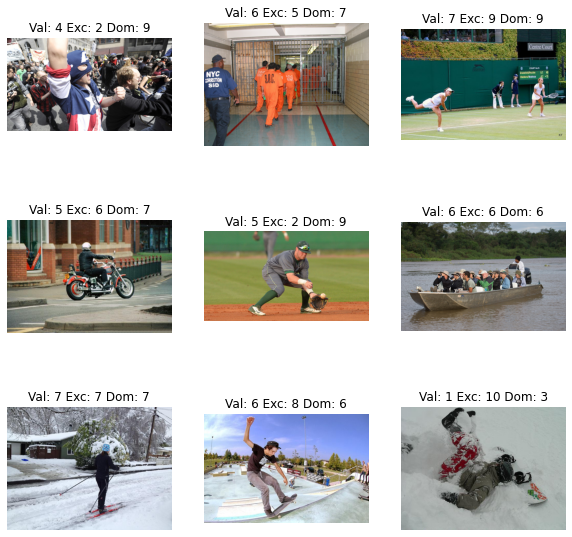

In [7]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

Posteriormente, se generan multiples datasets a partir de los DataFrames cargados que serán utilizados ya sea para entrenar los modelos o validar su funcionamiento tanto de forma aislada como conjunta.

In [243]:
train_list_ds_bbox = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','x1','y1','x2','y2']])
train_list_ds_bbox = train_list_ds_bbox.shuffle(len(train_list_ds_bbox), reshuffle_each_iteration=False)

train_list_ds_reg = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','valencia','excitacion','dominancia']])
train_list_ds_reg = train_list_ds_reg.shuffle(len(train_list_ds_reg), reshuffle_each_iteration=False)

In [244]:
val_list_ds_bbox = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','x1','y1','x2','y2']])
val_list_ds_bbox = val_list_ds_bbox.shuffle(len(val_list_ds_bbox), reshuffle_each_iteration=False)

val_list_ds_reg = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','valencia','excitacion','dominancia']])
val_list_ds_reg = val_list_ds_reg.shuffle(len(val_list_ds_reg), reshuffle_each_iteration=False)

In [245]:
test_list_ds_bbox = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','x1','y1','x2','y2']])
test_list_ds_bbox = test_list_ds_bbox.shuffle(len(test_list_ds_bbox), reshuffle_each_iteration=False)

test_list_ds_reg = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','valencia','excitacion','dominancia']])
test_list_ds_reg = test_list_ds_reg.shuffle(len(test_list_ds_reg), reshuffle_each_iteration=False)

In [307]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
train_list_ds = train_list_ds.shuffle(len(train_list_ds), reshuffle_each_iteration=False)

val_list_ds = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
val_list_ds = train_list_ds.shuffle(len(val_list_ds), reshuffle_each_iteration=False)

test_list_ds = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
test_list_ds = train_list_ds.shuffle(len(test_list_ds), reshuffle_each_iteration=False)

## Preprocesamiento y preparación de los datos
Para el preprocesamiento de los datos, inicialmente se definen distintas constantes a utilizar a lo largo de la implementación de los modelos.

In [246]:
BATCH_SIZE = 64
TRAIN_SIZE = len(train_list_ds_bbox)
VAL_SIZE = len(val_list_ds_bbox)
TEST_SIZE = len(test_list_ds_bbox)
SIZE = (200, 200)

Después, se parte por la tarea de predicción de bounding boxes para lo cual se definen y aplican sobre los datasets dos funciones de *tensorflow*: una para la carga de las imágenes y otra para el procesamiento del bounding box.

In [247]:
@tf.function
def parse_ds_bbox_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.

    x1 = tf.strings.to_number(example_input[1])
    y1 = tf.strings.to_number(example_input[2])
    x2 = tf.strings.to_number(example_input[3])
    y2 = tf.strings.to_number(example_input[4])

    return image, {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}

@tf.function
def process_bbox(image: Optional[tf.Tensor], output: Optional[Dict[str,tf.Tensor]],) -> Optional[Tuple[tf.Tensor]]:
    shape = tf.shape(image)    
    image = tf.image.resize(image, SIZE)
    x_scale = 200. / tf.cast(shape[1], tf.float32)
    y_scale = 200. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(output['y1'] * y_scale),
            tf.round(output['x1'] * x_scale),
            tf.round(output['y2'] * y_scale),
            tf.round(output['x2'] * x_scale),]

    return image, bbox

In [248]:
train_ds_bbox = train_list_ds_bbox.map(parse_ds_bbox_function)
train_ds_bbox = train_ds_bbox.map(process_bbox)

val_ds_bbox = val_list_ds_bbox.map(parse_ds_bbox_function)
val_ds_bbox = val_ds_bbox.map(process_bbox)

test_ds_bbox = test_list_ds_bbox.map(parse_ds_bbox_function)
test_ds_bbox = test_ds_bbox.map(process_bbox)

A continuación se valida la correcta implementación de este dataset al ilustrar algunas imágenes aleatorias con sus bounding boxes.

In [93]:
imgs = []
for img, bbox in train_ds_bbox.take(4):
    new_img = cv2.rectangle(img.numpy(), (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    imgs.append(new_img)

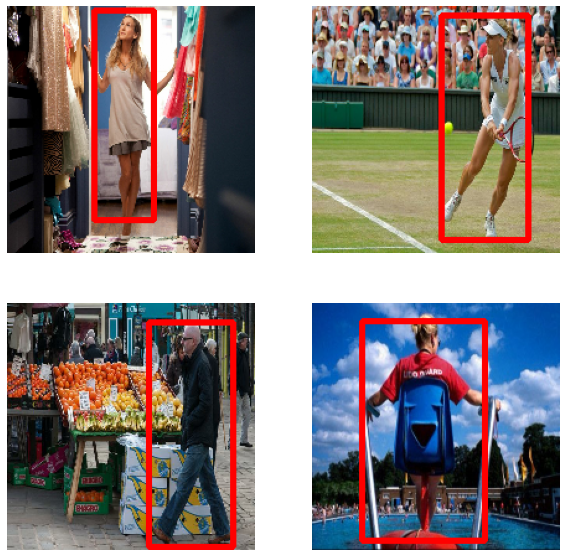

In [94]:
visualize_subplot(imgs, ["" for _ in imgs], (2, 2), (10, 10),)

Luego, se efectúa la misma labor sobre los datasets asociados a la predicción de los valores numéricos que codifican la emoción de la persona.

In [241]:
@tf.function
def parse_ds_reg_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, SIZE)
    image = tf.cast(image, tf.float32) / 255.
    
    val = tf.strings.to_number(example_input[1])
    exc = tf.strings.to_number(example_input[2])
    dom = tf.strings.to_number(example_input[3])

    return image, [val, exc, dom]

In [249]:
train_ds_reg = train_list_ds_reg.map(parse_ds_reg_function)
val_ds_reg = val_list_ds_reg.map(parse_ds_reg_function)
test_ds_reg = test_list_ds_reg.map(parse_ds_reg_function)

Posteriormente, se agrupan las dos labores en una sola función para poder evidenciar al final el desempeño de ambos modelos sobre las mismas imágenes en un dataset aparte.

In [310]:
@tf.function
def parse_ds_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    
    x1 = tf.strings.to_number(example_input[1])
    y1 = tf.strings.to_number(example_input[2])
    x2 = tf.strings.to_number(example_input[3])
    y2 = tf.strings.to_number(example_input[4])
    
    shape = tf.shape(image)    
    image = tf.image.resize(image, SIZE)
    x_scale = 200. / tf.cast(shape[1], tf.float32)
    y_scale = 200. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(y1 * y_scale),
            tf.round(x1 * x_scale),
            tf.round(y2 * y_scale),
            tf.round(x2 * x_scale),]
    
    val = tf.strings.to_number(example_input[5])
    exc = tf.strings.to_number(example_input[6])
    dom = tf.strings.to_number(example_input[7])

    return image, bbox, [val, exc, dom]

Finalmente, se modelan los datasets como conjuntos infinitos de manera que se pase por todas las imágenes al iterar sobre ellos múltiples veces.

In [311]:
train_ds = train_list_ds.map(parse_ds_function)
val_ds = val_list_ds.map(parse_ds_function)
test_ds = test_list_ds.map(parse_ds_function)

In [250]:
def performance(dataset: Optional[tf.data.Dataset], train: bool = True,) -> Optional[tf.data.Dataset]:
    if train:
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [251]:
train_ds_bbox = performance(train_ds_bbox)
train_ds_reg  = performance(train_ds_reg)

val_ds_bbox = performance(val_ds_bbox, False)
val_ds_reg = performance(val_ds_reg, False)

test_ds_bbox = performance(test_ds_bbox, False)
test_ds_reg = performance(test_ds_reg, False)

In [312]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

## Modelado
### Bounding box
Ahora bien, para el planteamiento de los modelos, se inicia por la arquitectura asociada al predictor de bounding boxes y posteriormente se compila con la función de pérdida asociada a la intersección sobre la unión utilizada en este tipo de tareas.

In [41]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(*SIZE, 3)))
vgg.trainable = False

flatten_bbox = Flatten()(vgg.output)
dense_1_bbox = Dense(128, activation = 'relu')(flatten_bbox)
dense_2_bbox = Dense(32, activation = 'relu')(dense_1_bbox)
output_bbox = Dense(4, activation = lambda x: 200*tf.keras.activations.sigmoid(x))(dense_2_bbox)
model_bbox_base = Model(inputs = vgg.inputs, outputs = output_bbox)
model_bbox_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [43]:
model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
                 loss = GIoU_Loss)

Se define de igual forma como criterio de parada el hecho de que la pérdida en validación deje de disminuir ya que en dicho punto se empezaría a hacer un sobreajuste de los datos.

In [255]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

Y se procede a entrenar este primer modelo. Como se observa, el comportamiento de la pérdida no es el deseado lo que se comprueba con el conjunto de imágenes aleatorio del conjunto de validación más adelante.

In [44]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 250,
    "validation_data": val_ds_bbox,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_bbox_base.fit(train_ds_bbox, **params)

Epoch 1/250
195/195 [==============================] - 2240s 11s/step - loss: 1.0015 - val_loss: 1.0000
Epoch 2/250
195/195 [==============================] - 2245s 12s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/250
195/195 [==============================] - 2233s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/250
195/195 [==============================] - 2230s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/250
195/195 [==============================] - 2236s 11s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 00005: early stopping


In [52]:
for X_batch, y_batch in val_ds_bbox.take(1):
    break
np.random.seed(2)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_bboxs = y_batch.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [53]:
imgs = []
labels = []
for img, bbox, pred_bbox in zip(X_img, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    imgs.append(new_img)
    labels.append("")

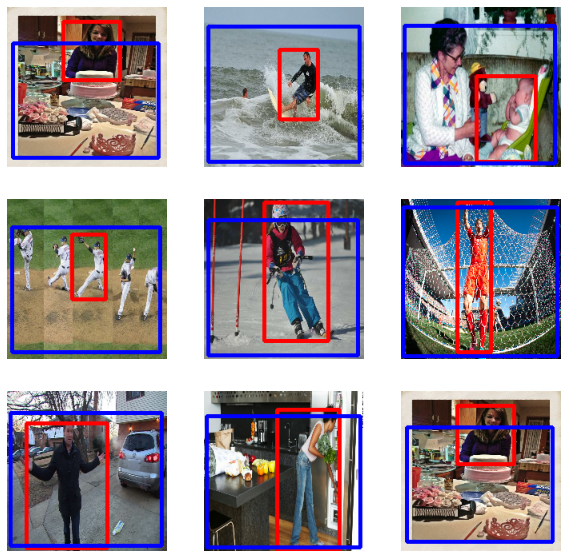

In [54]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

Debido a que no se obtuvo el comportamiento esperado, se procede a utilizar una función de pérdida diferente. Dado que la tarea en cuestión corresponde a una regresión, se utiliza el MSE. Como se muestra más adelante, el comportamiento en esta ocasión es el esperado ya que en los casos con una sola persona, las predicciones son cercanas al valor real.

In [55]:
model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')

In [57]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds_bbox,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_bbox_base.fit(train_ds_bbox, **params)

Epoch 1/50
195/195 [==============================] - 2236s 11s/step - loss: 457.2716 - val_loss: 416.0898
Epoch 2/50
195/195 [==============================] - 2250s 12s/step - loss: 420.2852 - val_loss: 392.0949
Epoch 3/50
195/195 [==============================] - 2236s 11s/step - loss: 391.3178 - val_loss: 356.8856
Epoch 4/50
195/195 [==============================] - 2239s 12s/step - loss: 360.8013 - val_loss: 323.9194
Epoch 5/50
195/195 [==============================] - 2233s 11s/step - loss: 334.7567 - val_loss: 297.7755
Epoch 6/50
195/195 [==============================] - 2236s 11s/step - loss: 303.4906 - val_loss: 274.0227
Epoch 7/50
195/195 [==============================] - 2257s 12s/step - loss: 275.7411 - val_loss: 254.5435
Epoch 8/50
195/195 [==============================] - 2319s 12s/step - loss: 254.6010 - val_loss: 236.4429
Epoch 9/50
195/195 [==============================] - 2295s 12s/step - loss: 230.6547 - val_loss: 217.5581
Epoch 10/50
195/195 [================

In [105]:
for X_batch, y_batch in val_ds_bbox.take(1):
    break
np.random.seed(1)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_bboxs = y_batch.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [106]:
imgs = []
labels = []
for img, bbox, pred_bbox in zip(X_img, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    imgs.append(new_img)
    labels.append("")

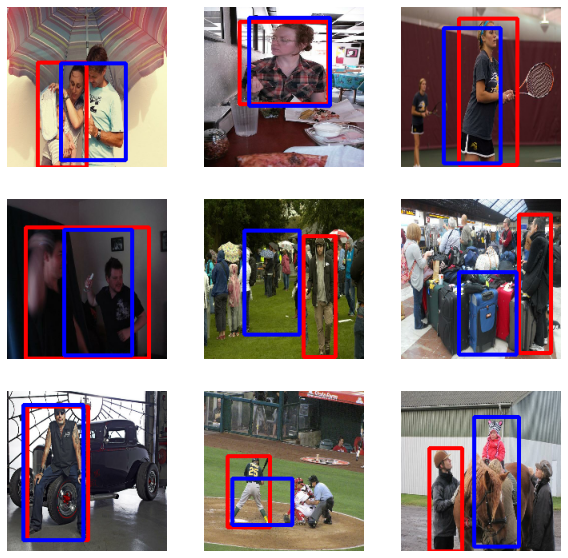

In [107]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

Debido a que el modelo tiene el desempeño esperado, sus pesos son guardados en archivos localmente.

In [82]:
model_bbox_base.save_weights('modelo_bbox_mse_weights', save_format='tf')

### Detección de emociones
De forma análoga, se plantea un modelo base para la tarea de regresión partiendo de la red InceptionV3 que permite extraer múltiples características de las imágenes. En la tarea anterior, se utilizó la red VGG16 ya que es usada comunmente para detectar bounding boxes. Debido a que le valor de la métrica en los datos de validación se encuentra por debajo del umbral establecido, se almacena también este modelo.

In [258]:
inception = keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(*SIZE, 3),)
inception.trainable = False

flatten_emo = Flatten()(inception.output)
dense_1_emo = Dense(128, activation = 'relu')(flatten_emo)
dense_2_emo = Dense(32, activation = 'relu')(dense_1_emo)
output_emo = Dense(3, activation = lambda x: 10*tf.keras.activations.sigmoid(x))(dense_2_emo)
model_reg_base = Model(inputs = inception.inputs, outputs = output_emo)

model_reg_base.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_294 (Conv2D)            (None, 99, 99, 32)   864         ['input_36[0][0]']               
                                                                                                  
 batch_normalization_282 (Batch  (None, 99, 99, 32)  96          ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [259]:
model_reg_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
                 loss = 'mse')

In [260]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds_reg,
    "verbose": 1,
    "callbacks": callbacks
}
history = model_reg_base.fit(train_ds_reg, **params)

Epoch 1/50
195/195 [==============================] - 302s 2s/step - loss: 4.0791 - val_loss: 1.7025
Epoch 2/50
195/195 [==============================] - 297s 2s/step - loss: 3.0234 - val_loss: 1.5888
Epoch 3/50
195/195 [==============================] - 297s 2s/step - loss: 2.7504 - val_loss: 1.5736
Epoch 4/50
195/195 [==============================] - 298s 2s/step - loss: 2.4982 - val_loss: 1.6252
Epoch 5/50
195/195 [==============================] - 298s 2s/step - loss: 2.3406 - val_loss: 1.5536
Epoch 6/50
195/195 [==============================] - 298s 2s/step - loss: 2.1825 - val_loss: 1.5145
Epoch 7/50
195/195 [==============================] - 297s 2s/step - loss: 2.0612 - val_loss: 1.5321
Epoch 8/50
195/195 [==============================] - 298s 2s/step - loss: 1.9315 - val_loss: 1.6471
Epoch 9/50
195/195 [==============================] - 298s 2s/step - loss: 1.8101 - val_loss: 1.7404
Epoch 00009: early stopping


In [264]:
model_reg_base.save_weights('modelo_reg_mse_weights', save_format='tf')

Finalmente, se comprueba el funcionamiento de ambas redes seleccionadas de forma conjunta. Como se observa, los bounding boxes logran detectar de forma acertada la posición de las personas que se encuentran en primer plano; cuando hay más de una persona tiende a perder un poco de precisión. En cuanto a los tres valores que indican la emoción, en general se encuentran cercanos a los valores originales.

In [322]:
for X_batch, y_batch_bbox, y_batch_reg in test_ds.take(1):
    break
np.random.seed(7)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_reg = y_batch_reg.numpy()[random_sample]
y_reg_pred = model_reg_base.predict(X_img)
y_bboxs = y_batch_bbox.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)

In [323]:
imgs = []
labels = []
for img, reg, reg_pred, bbox, pred_bbox in zip(X_img, y_reg, y_reg_pred, y_bboxs, y_bboxs_pred):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    str_real = "Real: Val: " + str(round(reg[0])) + "; Exc: " + str(round(reg[1])) + "; Dom: " + str(round(reg[2]))
    str_pred = "\nPred: Val: " + str(round(pred_reg[0])) + "; Exc: " + str(round(pred_reg[1])) + "; Dom: " + str(round(pred_reg[2]))
    imgs.append(new_img)
    labels.append(str_real + str_pred)

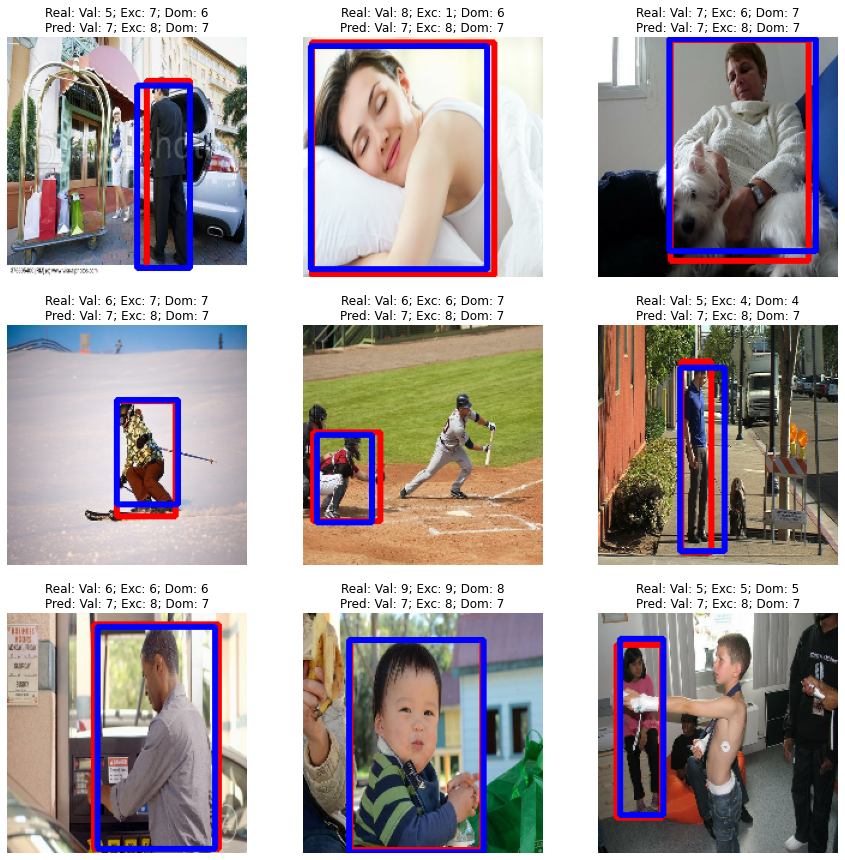

In [324]:
visualize_subplot(imgs, labels, (3, 3), (15, 15),)

## Evaluación
Por último, se calcula el RMSE de los modelos sonre el conjunto de test que no se utilizó en ninguna instancia del entrenamiento. Se calcula esta métrica ya que permite interpretar el resultado global en términos de las escalas de las variables predecidas.

In [326]:
score_test_bbox = model_bbox_base.evaluate(test_ds_bbox, steps=TEST_SIZE // BATCH_SIZE)

40/40 [==============================] - 266s 7s/step - loss: 760.1434


In [332]:
print('RMSE:', score_test_bbox**0.5)

RMSE: 27.570698805383724


In [329]:
score_test_reg = model_reg_base.evaluate(test_ds_reg, steps=TEST_SIZE // BATCH_SIZE)

40/40 [==============================] - 59s 1s/step - loss: 2.3071


In [333]:
print('RMSE:', score_test_reg**0.5)

RMSE: 1.518900762539634
